How should we handle a stochastic model? In computing the sensitivity measures, is it sufficient to run the model *once* for each sample parameter set, should we use an average over many runs for each sample parameter set, or maybe even just a few runs for each parameter set?

We really need a maximum time for the simulations.

Can we do some kind of survival regression on extinction time and extinction observation?

# Persistence time of a general epidemic

The stochastic general epidemic model with counts $(S, I, R)$ of the number of people susceptible, infectious, and recovered, has events:

* Birth: $(S, I, R) \to (S + 1, I, R)$ with hazard $\mu N$;
* Death of a susceptible: $(S, I, R) \to (S - 1, I, R)$ with hazard $\mu S$;
* Death of an infectious: $(S, I, R) \to (S, I - 1, R)$ with hazard $\mu I$;
* Death of a recovered: $(S, I, R) \to (S, I, R - 1)$ with hazard $\mu R$;
* Infection: $(S, I, R) \to (S - 1, I + 1, R)$ with hazard $\frac{\beta I}{N} S$; and
* Recovery: $(S, I, R) \to (S, I - 1, R + 1)$ with hazard $\gamma I$;

where $N = S + I + R$.

The basic reproduction number is
$$R_0 = \frac{\beta}{\gamma + \mu}.$$

When $R_0 > 1$, we will use the endemic equilibrium of the deterministic model
$$\begin{aligned}
\frac{\mathrm{d} S}{\mathrm{d} t} &= \mu N - \frac{\beta I}{N} S - \mu S,\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \frac{\beta I}{N} S - \gamma I - \mu I,\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I - \mu R,
\end{aligned}$$
as the expected value of a multinomial distribution to determine the initial condition for the stochastic model:
$$\left(S(0), I(0), R(0)\right)
= \mathrm{Multinomial}(N_0, p),$$
where
$$p = \left(\frac{1}{R_0},
            \frac{\mu}{\beta}\left(R_0 - 1\right),
            \frac{\gamma}{\beta}\left(R_0 - 1\right)\right),$$
and $N_0$ is the initial population size.
We will resample from this multinomial until we get an initial condition with $I(0) > 0$.

We will simulate the stochastic model using the Gillespie algorithm.

For each simulation, we will find the extinction time, the first time with $I(t) = 0$.

In [1]:
import lifelines
import numpy
import pandas
from scipy import stats

import sensitivity_analysis
import persistence

In [2]:
persistence.get_persistence_time(0.012, 0.01, 0.001, seed=1)

2171.1930732740902

Let's take the parameters to be the random variables
$$\begin{aligned}
\beta &\sim \Gamma(0.03, 4),\\
\gamma &\sim \Gamma(0.01, 4),\\
\mu &\sim \Gamma(0.001, 4),
\end{aligned}$$
where $\Gamma(a, k)$ is the gamma random variable with mean $a$ and shape $k$.

In [3]:
parameters = persistence.get_parameters()

In [4]:
n_samples = 100
seed_seq = numpy.random.SeedSequence(1)
samples = sensitivity_analysis.samples_Latin_hypercube(parameters,
                                                       n_samples=n_samples,
                                                       seed=persistence.get_seed(seed_seq))
persistence_times = persistence.run_many(persistence.get_persistence_time,
                                         samples,
                                         seed=persistence.get_seed(seed_seq))

In [ ]:
samples = pandas.DataFrame(numpy.load('samples.npy'),
                           columns=parameters.keys())
persistence_times = numpy.load('persistence.npy')
persistence_times

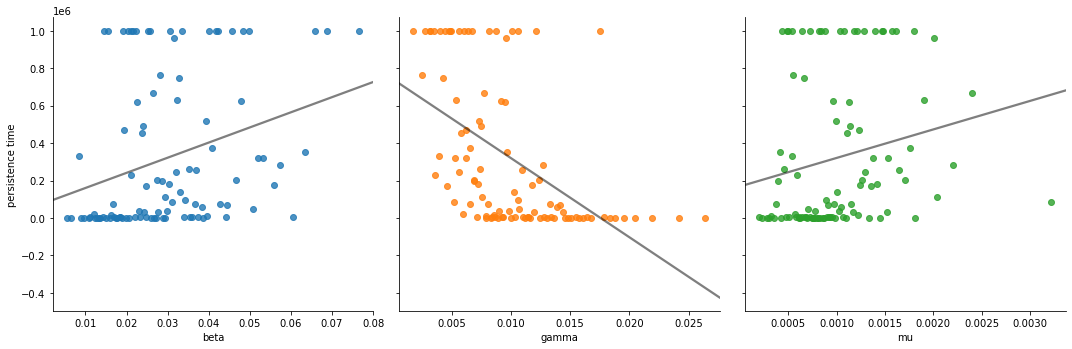

In [5]:
fg = sensitivity_analysis.scatterplots_samples(samples, persistence_times)
_ = fg.set_ylabels('persistence time')

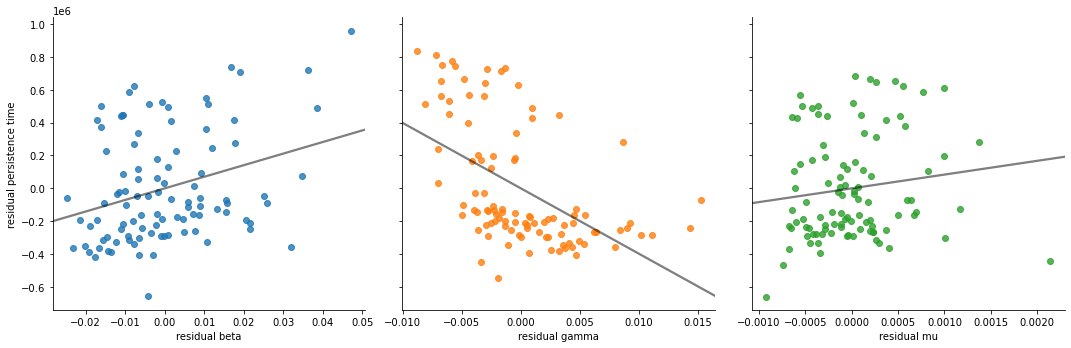

In [6]:
fg = sensitivity_analysis.residualplots_samples(samples, persistence_times)
_ = fg.set_ylabels('residual persistence time')

In [7]:
table = {}
table[r'$\beta_{\sigma}$'] = sensitivity_analysis.linreg_coefficients_samples(
    samples, persistence_times)
table[r'$\rho_{\mathrm{partial\ rank}}$'] = sensitivity_analysis.PRCC_samples(
    samples, persistence_times)
table = pandas.DataFrame(table)
table

,$\beta_{\sigma}$,$\rho_{\mathrm{partial\ rank}}$
beta,0.262363,0.571367
gamma,-0.495914,-0.749544
mu,0.109482,0.325397


In [10]:
# Format input and output for `lifeines`.
df = samples.copy()
df['duration'] = persistence_times
# Extinction was observed if the persistence time is less than 1e6.
df['event'] = (df['duration'] <= 1e6)
# Drop simulations that started extinct, i.e. R_0 < 1.
# df = df[df['duration'] > 0]

/home/medlock/.local/lib/python3.8/site-packages/lifelines/utils/__init__.py:1079: ConvergenceWarning: Column(s) ['gamma', 'mu'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 100 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 100
   partial log-likelihood = -319.48
         time fit was run = 2020-08-11 00:34:42 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
beta       -47.61       0.00       7.76           -62.83           -32.39                 0.00                 0.00
gamma      245.86  5.99e+106      28.14           190.71           301.02             6.64e+82            5.40e+130
mu        -580.37       0.00     235.58         -1042.09          -118.65                 0.00                 0.00
              z      p   -log2(p)
covariate                        
beta      -6.13 <0.005      30.10
gamma      8.74 <0.005      58.53
mu        -2.46   0.01       6.18
---
Concordance = 0.83
Partial AIC = 644.97
log-likelihood ratio test = 88.51 on 3 df
-log2(p) of ll-ratio test = 60.92

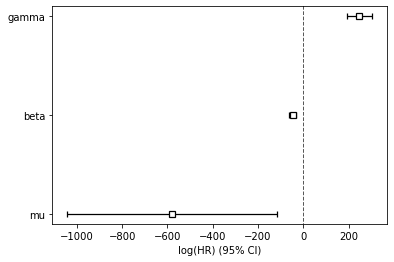

In [11]:
cph = lifelines.CoxPHFitter()
cph.fit(df, duration_col='duration', event_col='event')
cph.plot()
cph.print_summary()

In [50]:
# The regression coefficients.
beta = cph.summary['coef']
beta

covariate
beta     -47.612816
gamma    245.863870
mu      -580.373874
Name: coef, dtype: float64

In [51]:
# The regression coefficients scaled by the standard deviations.
beta_sigma = beta * samples.std(ddof=1) / numpy.std(persistence_times, ddof=1)
beta_sigma

covariate
beta    -1.773923e-06
gamma    3.063487e-06
mu      -7.593694e-07
dtype: float64

<lifelines.AalenAdditiveFitter: fitted with 100 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
       number of subjects = 100
number of events observed = 100
         time fit was run = 2020-08-11 00:34:59 UTC

---
Empty DataFrame
Columns: []
Index: [beta, gamma, mu, Intercept]
---
Concordance = 0.83

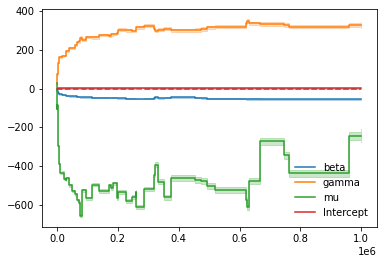

In [12]:
aaf = lifelines.AalenAdditiveFitter()
aaf.fit(df, duration_col='duration', event_col='event')
aaf.plot()
aaf.print_summary()

In [46]:
# The regression coefficients.
beta = aaf.summary['slope(coef)'].drop('Intercept')
beta

covariate
beta    -0.000264
gamma    0.001520
mu      -0.002598
Name: slope(coef), dtype: float64

In [47]:
# The regression coefficients scaled by the standard deviations.
beta_sigma = beta * samples.std(ddof=1) / numpy.std(persistence_times, ddof=1)
beta_sigma

covariate
beta    -9.852908e-12
gamma    1.894530e-11
mu      -3.398914e-12
dtype: float64